In [2]:
import os
import torch
import numpy as np
from pytorch3d.renderer import PerspectiveCameras, BlendParams, RasterizationSettings, MeshRenderer, MeshRasterizer, SoftSilhouetteShader, Textures
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, join_meshes_as_scene, join_meshes_as_batch
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytorch3d

In [3]:
# Set the device
if torch.cuda.is_available():
	device = torch.device("cuda:0")
else:
	device = torch.device("cpu")
	print("WARNING: CPU only, this will be slow!")


### Get all mesh files

In [40]:
base_dir = "/home/sscekic/master-thesis/src"
mesh_files = [os.path.join(base_dir, "urdfs/meshes/visual/link0/link0.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/link1/link1.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/link2/link2.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/link3/link3.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/link4/link4.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/link5/link5.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/link6/link6.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/link7/link7.obj"),
			  os.path.join(base_dir, "urdfs/meshes/visual/hand/hand.obj")
			  ]

### Load all mesh files into objects

In [53]:
from os.path import exists

verts = []
faces = []
for m_file in mesh_files:
	assert exists(m_file)
	preload_verts_i, preload_faces_idx_i, _ = load_obj(m_file)
	preload_faces_i = preload_faces_idx_i.verts_idx
	verts.append(preload_verts_i)
	faces.append(preload_faces_i)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has no attribute '_evt'
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/sscekic/anaconda3/envs/nerf/lib/python3.12/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
        ^^^^^^^^^
AttributeError: 'NativePathHandler' object has 

### Setup cameras and renderer

In [54]:

from pytorch3d.renderer import FoVPerspectiveCameras

focal_length = [960.41357421875, 960.22314453125]
principal_point = [1021.7171020507812, 776.2381591796875]
image_size = [1536, 2048]
cameras = PerspectiveCameras(focal_length=focal_length,
							 principal_point=principal_point,
							 device=device,
							 in_ndc=False, image_size=image_size)

blend_params = BlendParams(sigma=1e-8, gamma=1e-8)
raster_settings = RasterizationSettings(
	image_size=image_size,
	blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
	faces_per_pixel=100,
	max_faces_per_bin=100000,  # max_faces_per_bin=1000000,
)

silhouette_renderer = MeshRenderer(
	rasterizer=MeshRasterizer(
		cameras=cameras,
		raster_settings=raster_settings
	),
	shader=SoftSilhouetteShader(blend_params=blend_params)
)

### Define function for getting rotation and translation matrix

In [55]:
# Instance of ERobot and angles for forward kinematics
def get_joint_RT(robot, joint_angle):
	link_idx_list = [0, 1, 2, 3, 4, 5, 6, 7, 9]
	# link 0,1,2,3,4,5,6,7, and hand
	R_list = []
	t_list = []

	for i in range(len(link_idx_list)):
		link_idx = link_idx_list[i]
		T = robot.fkine(joint_angle, end=robot.links[link_idx], start=robot.links[0])
		R_list.append(T.R)
		t_list.append(T.t)

	return np.array(R_list), np.array(t_list)


### Define Panda robot model class

In [56]:
from roboticstoolbox import ERobot


class Panda(ERobot):
	"""
    Class that imports a URDF model
    """

	def __init__(self, urdf_file):
		links, name, urdf_string, urdf_filepath = self.URDF_read(urdf_file)

		super().__init__(
			links,
			name=name,
			manufacturer="Franka",
			urdf_string=urdf_string,
			urdf_filepath=urdf_filepath,
			# gripper_links=elinks[9]
		)


panda = Panda(urdf_file=os.path.join(base_dir, "urdfs/panda.urdf"))


### Get rotation and translation matrices for robot

In [57]:
joint_angles = np.array([0.0200, -0.9641, -0.0662, -2.7979, -0.0469, 1.9289, 0.9137])
R_list, T_list = get_joint_RT(panda, joint_angles)

### Apply transofrmations on meshes

In [58]:
print(len(mesh_files))
print(R_list.shape[0])
print(T_list.shape[0])

9
9
9


In [59]:
assert len(mesh_files) == R_list.shape[0] and len(mesh_files) == T_list.shape[0]
verts_list = []
faces_list = []
verts_rgb_list = []
verts_count = 0
for i in range(len(mesh_files)):
	# Get verts
	verts_i = verts[i]
	# Get faces
	faces_i = faces[i]

	# Convert tensors to right type
	R = torch.tensor(R_list[i], dtype=torch.float32)
	t = torch.tensor(T_list[i], dtype=torch.float32)

	verts_i = verts_i @ R.T + t
	faces_i = faces_i + verts_count

	verts_count += verts_i.shape[0]

	verts_list.append(verts_i.to(device))
	faces_list.append(faces_i.to(device))

	# Initialize each vertex to be white in color.
	color = torch.rand(3)
	verts_rgb_i = torch.ones_like(verts_i) * color  # (V, 3)
	verts_rgb_list.append(verts_rgb_i.to(device))

# Concat all verts and faces
verts = torch.concat(verts_list, dim=0)
faces = torch.concat(faces_list, dim=0)

verts_rgb = torch.concat(verts_rgb_list, dim=0)[None]
textures = Textures(verts_rgb=verts_rgb)

# Create a Meshes object
robot_mesh = Meshes(
	verts=[verts.to(device)],
	faces=[faces.to(device)],
	textures=textures
)

In [51]:
print(R_list)
test_R = torch.concat(R_list, dim=0)
test_T = torch.concat(T_list, dim=0)

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99800007e-01 -1.99986667e-02  0.00000000e+00]
  [ 1.99986667e-02  9.99800007e-01  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 5.70042462e-01  8.21371807e-01 -1.99986667e-02]
  [ 1.14023696e-02  1.64296268e-02  9.99800007e-01]
  [ 8.21536108e-01 -5.70156490e-01  4.89658886e-12]]

 [[ 5.70116775e-01  1.77543926e-02 -8.21371807e-01]
  [-5.47610342e-02  9.98364311e-01 -1.64296268e-02]
  [ 8.19736599e-01  5.43459754e-02  5.70156490e-01]]

 [[-2.60000079e-01  9.65445359e-01 -1.77543926e-02]
  [ 5.70946599e-02 -2.98384139e-03 -9.98364311e-01]
  [-9.63919166e-01 -2.60588481e-01 -5.43459754e-02]]

 [[-2.60546558e-01  5.54533595e-03  9.65445359e-01]
  [ 1.02257559e-02  9.99943264e-01 -2.98384140e-03]
  [-9.65407129e-01  9.09497894e-03 -2.60588481e-01]]

 [[ 9.95521828e-01 -9.43691633e-02 -5.54533594e-03]


TypeError: concat() received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [33]:
print(R.shape)
print(T.shape)

torch.Size([3, 3])


NameError: name 'T' is not defined

In [28]:
focal_length = [960.41357421875, 960.22314453125]
principal_point = [1021.7171020507812, 776.2381591796875]
image_size = [1536, 2048]
cameras = FoVPerspectiveCameras(R=R, T=T)

blend_params = BlendParams(sigma=1e-8, gamma=1e-8)
raster_settings = RasterizationSettings(
	image_size=image_size,
	blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
	faces_per_pixel=100,
	max_faces_per_bin=100000,  # max_faces_per_bin=1000000,
)

silhouette_renderer = MeshRenderer(
	rasterizer=MeshRasterizer(
		cameras=cameras,
		raster_settings=raster_settings
	),
	shader=SoftSilhouetteShader(blend_params=blend_params)
)

In [31]:
images = silhouette_renderer(meshes_world=robot_mesh)

ValueError: Wrong number (9) of cameras for 1 meshes

### Render image

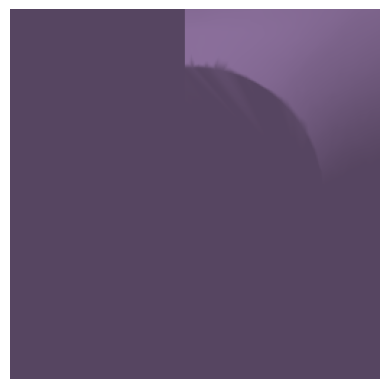

In [26]:
plt.imshow(images.squeeze().detach().cpu().numpy())
plt.axis("off")
plt.show()